In [1]:
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt
from deepdow.benchmarks import OneOverN, Random, Benchmark
from deepdow.callbacks import EarlyStoppingCallback
from deepdow.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from deepdow.data.synthetic import sin_single
from deepdow.experiments import Run
from deepdow.layers import SoftmaxAllocator
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from deepdow.utils import raw_to_Xy

2023-09-05 11:52:47.124359: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-05 11:52:47.166492: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 11:52:47.975711: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn import set_config; set_config(display='diagram')

key = os.environ.get('API_KEY')

# Step 1: Define a function to read CSV files and convert them to dataframes
# Get the current working directory (where your script is located)
current_directory = os.getcwd()

# Specify the path to the "raw_data" folder
raw_data_folder = os.path.join(current_directory, "raw_data")

# List all CSV files in the "raw_data" folder
csv_files = [os.path.join(raw_data_folder, file) for file in os.listdir(raw_data_folder) if file.endswith(".csv")]

# passing csv files in to a dataframe
dataframes = [pd.read_csv(file) for file in csv_files]



# Step 2: Define a function to read CSV files and convert them to dataframes
def read_csv_to_dataframe(file_path):
    df = pd.read_csv(file_path)
    return df

# Step 4: Read CSV files, preprocess data, and stack them into a 3D tensor
data = []
stock_names =[]

# print(type(csv_files))

for file in csv_files:
    # Read the CSV file into a DataFrame
    data_df = pd.read_csv(file)
    stock_name = file.split('/')[-1].split('.')[0]
    stock_names.append(stock_name)
    data_df["stock"] = stock_name
    data.append(data_df)

    impute_columns = ["sma25", "sma100", "sma200", "rsi", "macd", "signal", "histogram"]

imputer = Pipeline(
    [
        ('imputer', ColumnTransformer(
            transformers=[
                ('impute', KNNImputer(n_neighbors=10), impute_columns),  # Apply imputation to specific columns
            ],
            remainder='passthrough'  # Keep the remaining columns
        ))
    ]
)


def df_and_column_transform(arr):
    df = pd.DataFrame(arr, columns=["sma25", "sma100", "sma200", "rsi", "macd", "signal", "histogram",\
    "Unnamed: 0", "open", "high","low", "close", "volume", "vwap", "timestamp", "transactions", "otc", "stock"])

    first_col = df.pop("sma25")
    df.insert(16, "sma25", first_col)

    sec_col = df.pop("sma100")
    df.insert(16, "sma100", sec_col)

    third_col = df.pop("sma200")
    df.insert(16, "sma200", third_col)

    fourth_col = df.pop("rsi")
    df.insert(16, "rsi", fourth_col)

    fifth_col = df.pop("macd")
    df.insert(16, "macd", fifth_col)

    sixth_col = df.pop("signal")
    df.insert(16, "signal", sixth_col)

    seventh_col = df.pop("histogram")
    df.insert(16, "histogram", seventh_col)

    return df

transform_pipe = make_pipeline(
    FunctionTransformer(df_and_column_transform)
)

preprocessor = preprocessor = Pipeline(
    [
        ("transformation", transform_pipe),
    ],
)
preprocessor


def timestamp_transform(df):
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms').dt.date
    first_col = df.pop("date")
    df.insert(0, 'date', first_col)
    # df.set_index(keys='date', inplace=True)

    return df

time_pipe = make_pipeline(
    FunctionTransformer(timestamp_transform)
)

preprocessor = Pipeline(
    [
        ("transformation", transform_pipe),
        ("timestamp_convertor", time_pipe),
    ],
)
preprocessor

drop_columns = ["Unnamed: 0", 'timestamp', "transactions", "otc"]

def drop(df):
    unwanted_columns = drop_columns
    df = df.drop(columns=unwanted_columns)

    return df

drop_pipe = make_pipeline(
    FunctionTransformer(drop)
)

preprocessor = Pipeline(
    [
        ("transformation", transform_pipe),
        ("timestamp_convertor", time_pipe),
        ("unwanted_columns", drop_pipe),
    ],
)
sec_pipe = Pipeline(
    [
        ("imputer", imputer),
        ("preprocessor", preprocessor),
    ]
)
def final_transformation(arr):
    cols = ["open", "high", "low", "close", "volume", "vwap", "sma25", "sma100", "sma200", "rsi", "macd",\
        "signal", "histogram", "date", "stock"]
    df = pd.DataFrame(arr, columns=cols)

    first_col = df.pop("date")
    df.insert(0, "date", first_col)

    df.set_index(keys='date', inplace=True)

    return df

final_transformation_pipe = make_pipeline(
    FunctionTransformer(final_transformation)
)

final_processing = Pipeline(
    [
        ("final_transformation", final_transformation_pipe)
    ]
)
final_pipe = Pipeline(
    [
        ("imputer", imputer),
        ("preprocessor", preprocessor),
        ("transformation", final_processing)
    ]
)
dataframes = []

for df in data:
    preprocessed_df = final_pipe.fit_transform(df)

    dataframes.append(preprocessed_df)
    filtered_dataframes = []

for df in dataframes:
    if df.shape == (1257, 14):
        filtered_dataframes.append(df)
        unequal_shape = []

for df in dataframes:
    if df.shape != (1257, 14):
        unequal_shape.append(df)
        # Check
num_dataframes = len(dataframes)


unequal = len(unequal_shape)


f = len(filtered_dataframes)


def transform_dataframe(df):
    return df.pivot(columns='stock').swaplevel(0, 1, axis=1).sort_index(axis=1)

# Apply the transformation to each data frame
transformed_dataframes = [transform_dataframe(df) for df in filtered_dataframes]

# Merge all transformed data frames into one
merged_df = pd.concat(transformed_dataframes, axis=1)

def ret_df():
    return merged_df


raw_df = ret_df()

## Portfolio_1 

In [3]:
idx = pd.IndexSlice 
port1_close = raw_df.loc[idx[:], idx[:,'close']]

In [4]:
port1_close.columns.remove_unused_levels()

MultiIndex([(  'AMD', 'close'),
            (  'XOM', 'close'),
            (  'COF', 'close'),
            ( 'MSFT', 'close'),
            (  'MMM', 'close'),
            (    'C', 'close'),
            (   'MO', 'close'),
            (   'BA', 'close'),
            (  'AMT', 'close'),
            (  'USB', 'close'),
            (  'PEP', 'close'),
            ( 'CHTR', 'close'),
            ( 'INTC', 'close'),
            ( 'ADBE', 'close'),
            (   'CL', 'close'),
            ( 'SBUX', 'close'),
            ( 'SCHW', 'close'),
            (  'MET', 'close'),
            (   'GM', 'close'),
            (    'T', 'close'),
            (  'SPG', 'close'),
            (  'COP', 'close'),
            (  'LOW', 'close'),
            (   'KO', 'close'),
            ( 'GOOG', 'close'),
            (  'FDX', 'close'),
            (   'GE', 'close'),
            (    'V', 'close'),
            ( 'TMUS', 'close'),
            ( 'QCOM', 'close'),
            (   'MS', 'close'),
        

In [5]:
idx = pd.IndexSlice 
port1_rsi= raw_df.loc[idx[:], idx[:,'rsi']]

In [6]:
idx = pd.IndexSlice 
port1_high = raw_df.loc[idx[:], idx[:,'high']]

In [7]:
idx = pd.IndexSlice 
port1_histogram = raw_df.loc[idx[:], idx[:,'histogram']]

In [8]:
idx = pd.IndexSlice 
port1_sma25 = raw_df.loc[idx[:], idx[:,'sma25']]

In [9]:
idx = pd.IndexSlice 
port1_sma200 = raw_df.loc[idx[:], idx[:,'sma200']]

In [10]:
idx = pd.IndexSlice 
port1_volume = raw_df.loc[idx[:], idx[:,'volume']]

In [11]:
close = port1_close[['V', 'TXN','QCOM', 'PYPL', 'ORCL', 'NVDA', 'MSFT', 'MA', 'INTC', 'IBM', 'CSCO', 'CRM', 'AVGO', 'AMD', 'ADBE', 'ACN', 'AAPL']]

In [12]:
close

stock,V,TXN,QCOM,PYPL,ORCL,NVDA,MSFT,MA,INTC,IBM,CSCO,CRM,AVGO,AMD,ADBE,ACN,AAPL
,close,close,close,close,close,close,close,close,close,close,close,close,close,close,close,close,close
date,,,,,,,,,,,,,,,,,
2018-08-31,146.89,112.4,68.71,92.33,48.58,70.17,112.33,215.56,48.43,146.48,47.77,152.68,219.03,25.17,263.51,169.07,56.9075
2018-09-04,147.8,112.54,69.98,93.07,48.58,70.925,111.71,216.82,47.96,145.68,47.73,153.21,219.43,28.06,266.68,169.5,57.09
2018-09-05,142.67,111.13,70.89,89.05,48.04,69.605,108.49,211.16,47.72,146.66,47.27,148.65,221.42,28.51,256.14,168.64,56.7175
2018-09-06,144.5,110.89,70.36,89.0,47.71,68.18,108.74,212.77,47.26,146.39,47.28,148.83,215.97,27.84,259.75,169.36,55.775
2018-09-07,143.2,108.46,70.38,88.82,47.81,67.965,108.21,211.09,46.45,145.45,47.05,150.43,232.58,27.38,260.87,169.07,55.325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-24,239.47,165.59,108.51,60.71,112.91,471.63,319.97,397.67,32.59,143.55,55.24,205.51,854.46,101.8,512.43,314.14,176.38
2023-08-25,242.57,167.81,110.32,61.19,116.06,460.18,322.98,402.89,33.25,145.35,55.7,209.47,851.82,102.25,525.06,318.76,178.61


In [13]:
df_returns1 = close.pct_change()

# Remove the first row since it will have NaN values after computing returns
df_returns1 = df_returns1.dropna()

# Optional: If you want to rename the top-level column index from 'close' to 'returns':
df_returns1.columns = pd.MultiIndex.from_product([['returns'], df_returns1.columns.get_level_values(1)])

df_returns1

returns                                                    \
               close     close     close     close     close     close   
date                                                                     
2018-09-04  0.006195  0.001246  0.018483  0.008015  0.000000  0.010760   
2018-09-05 -0.034709 -0.012529  0.013004 -0.043193 -0.011116 -0.018611   
2018-09-06  0.012827 -0.002160 -0.007476 -0.000561 -0.006869 -0.020473   
2018-09-07 -0.008997 -0.021914  0.000284 -0.002022  0.002096 -0.003153   
2018-09-10  0.006145 -0.001291  0.027565  0.011034  0.021962  0.010557   
...              ...       ...       ...       ...       ...       ...   
2023-08-24 -0.011680 -0.024966 -0.023927 -0.017001 -0.041836  0.000998   
2023-08-25  0.012945  0.013407  0.016680  0.007906  0.027898 -0.024278   
2023-08-28  0.005194  0.005304  0.012328  0.007844  0.006721  0.017754   
2023-08-29  0.006193  0.011796  0.018804  0.013459  0.032609  0.041614   
2023-08-30  0.008315 -0.006855 -0.008174  0.009360  0.006465  0.015651   

                                                                        \
               close     close     close     close     close     close   
date                                                                     
2018-09-04 -0.005519  0.005845 -0.009705 -0.005461 -0.000837  0.003471   
2018-09-05 -0.028825 -0.026105 -0.005004  0.006727 -0.009638 -0.029763   
2018-09-06  0.002304  0.007625 -0.009640 -0.001841  0.000212  0.001211   
2018-09-07 -0.004874 -0.007896 -0.017139 -0.006421 -0.004865  0.010751   
2018-09-10  0.010812  0.002748 -0.003229  0.001375  0.000425  0.005916   
...              ...       ...       ...       ...       ...       ...   
2023-08-24 -0.021498 -0.008453 -0.040906  0.000976 -0.013219 -0.017310   
2023-08-25  0.009407  0.013126  0.020252  0.012539  0.008327  0.019269   
2023-08-28  0.002229  0.011293  0.011128  0.004610  0.008977  0.010741   
2023-08-29  0.014551  0.010333  0.020523  0.002945  0.006406  0.001134   
2023-08-30  0.000639  0.013191  0.003498  0.000621  0.002564  0.009294   

                                                              
               close     close     close     close     close  
date                                                          
2018-09-04  0.001826  0.114819  0.012030  0.002543  0.003207  
2018-09-05  0.009069  0.016037 -0.039523 -0.005074 -0.006525  
2018-09-06 -0.024614 -0.023501  0.014094  0.004269 -0.016617  
2018-09-07  0.076909 -0.016523  0.004312 -0.001712 -0.008068  
2018-09-10  0.034526  0.091673  0.017250  0.002839 -0.013421  
...              ...       ...       ...       ...       ...  
2023-08-24 -0.025234 -0.069725 -0.034444 -0.003805 -0.026170  
2023-08-25 -0.003090  0.004420  0.024647  0.014707  0.012643  
2023-08-28  0.010871  0.003521  0.009256  0.006745  0.008846  
2023-08-29  0.033504  0.032258  0.020097  0.007915  0.021810  
2023-08-30 -0.003899  0.005759  0.008713 -0.000912  0.015045  

[1256 rows x 17 columns]

In [14]:
# # Compute the returns for each stock
# df_returns = port_test_2.pct_change()

# # Remove the first row since it will have NaN values after computing returns
# df_returns = df_returns.dropna()

# # Optional: If you want to rename the top-level column index from 'close' to 'returns':
# df_returns.columns = pd.MultiIndex.from_product([['returns'], df_returns.columns.get_level_values(1)])

# df_returns


In [15]:
#set seed for reproducibility4
torch.manual_seed(4)
np.random.seed(5)

In [16]:
n_timesteps, n_assets = 1100, 17
lookback, gap, horizon = 40, 2, 20
n_samples = n_timesteps - lookback - horizon - gap + 1

In [17]:
# X, timestamps, y, asset_names, indicators = raw_to_Xy(port_test,
#                                                       lookback=lookback,
#                                                       gap=gap,
#                                                       freq="B",
#                                                       horizon=horizon)

In [18]:
split_ix = int(n_samples * 0.8)
split_ix

831

In [19]:
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
                                                     indices_test[0], indices_test[-1]))

Train range: 0:830
Test range: 891:1038


In [20]:
# Feature matrix X and target y
X_list, y_list = [], []

for i in range(lookback, n_timesteps - horizon - gap + 1):
    X_list.append(df_returns1.iloc[i - lookback:i, :])
    y_list.append(df_returns1.iloc[i + gap:i + gap + horizon, :])

In [21]:
X = np.stack(X_list, axis=0)[:, None, ...]
y = np.stack(y_list, axis=0)[:, None, ...]

In [22]:
means, stds = prepare_standard_scaler(X, indices=indices_train)

In [23]:
dataset = InRAMDataset(X, y, transform=Scale(means, stds))

In [24]:
dataloader_train = RigidDataLoader(dataset, indices=indices_train, batch_size=16)
dataloader_test = RigidDataLoader(dataset, indices=indices_test, batch_size=16)

In [25]:
class GreatNet(torch.nn.Module, Benchmark):
    def __init__(self, n_assets, lookback, p=0.5):
        super().__init__()

        n_features = n_assets * lookback

        self.dropout_layer = torch.nn.Dropout(p=p)
        self.dense_layer = torch.nn.Linear(n_features, n_assets, bias=True)
        self.allocate_layer = SoftmaxAllocator(temperature=None)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        n_samples, _, _, _ = x.shape
        x = x.view(n_samples, -1)  # flatten features
        x = self.dropout_layer(x)
        x = self.dense_layer(x)

        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

In [26]:
network = GreatNet(n_assets, lookback)

In [27]:
network = network.train()

In [28]:
loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio()

In [29]:
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.2),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=10)])

In [30]:
history = run.launch(100)

Epoch 52: 100%|██████████| 52/52 [00:01<00:00, 26.60it/s, loss=-0.19483, test_loss=0.07722]


Training interrupted
Training stopped early because there was no improvement in test_loss for 10 epochs


In [31]:
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

<Axes: xlabel='epoch'>

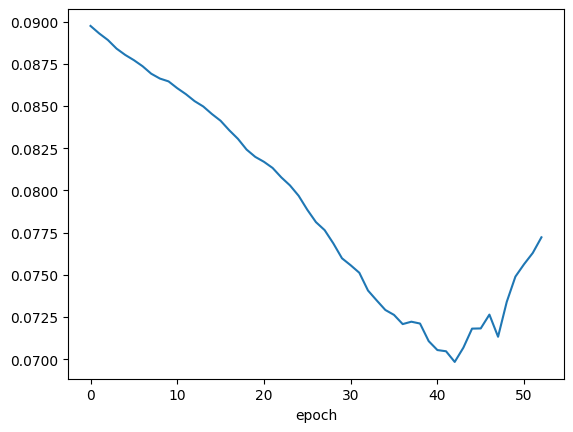

In [32]:
per_epoch_results.mean()['test']['loss']['network'].plot()

In [33]:
network = network.eval()

In [34]:
benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    'random': Random(),  # random allocation that is however close 1OverN
    'network': network
}

In [35]:
metrics = {
    'MaxDD': MaximumDrawdown(),
    'Sharpe': SharpeRatio(),
    'MeanReturn': MeanReturns()
}

In [36]:
metrics_table = generate_metrics_table(benchmarks,
                                       dataloader_test,
                                       metrics)

array([<Axes: title={'center': 'MaxDD'}, xlabel='timestamp'>,
       <Axes: title={'center': 'Sharpe'}, xlabel='timestamp'>,
       <Axes: title={'center': 'MeanReturn'}, xlabel='timestamp'>],
      dtype=object)

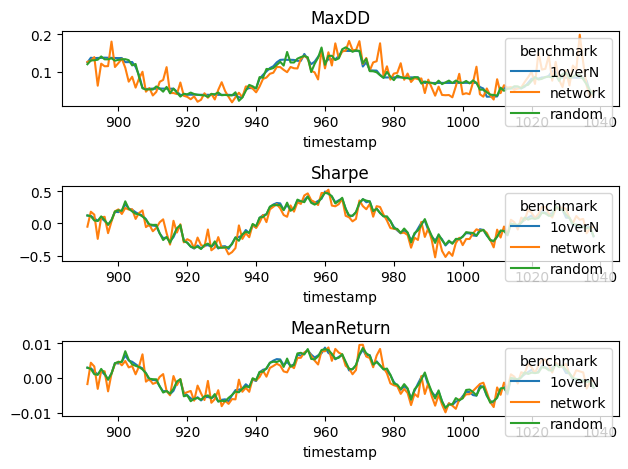

In [37]:
plot_metrics(metrics_table)

In [38]:
weight_table = generate_weights_table(network, dataloader_test)

<Axes: >

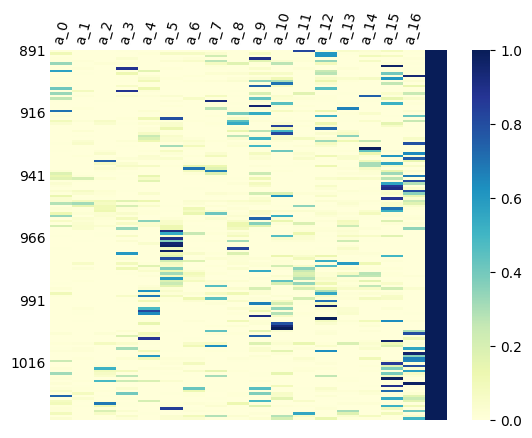

In [39]:
plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)

In [40]:
weight_table

           a_0       a_1       a_2       a_3       a_4       a_5       a_6  \
891   0.000185  0.000186  0.000221  0.007675  0.003583  0.001430  0.001392   
892   0.106082  0.000403  0.002162  0.000003  0.009328  0.067462  0.067505   
893   0.000077  0.000391  0.000435  0.000291  0.000110  0.000885  0.000776   
894   0.008728  0.002431  0.000191  0.032902  0.001057  0.004742  0.017267   
895   0.005118  0.012014  0.003256  0.000002  0.003416  0.028172  0.052220   
...        ...       ...       ...       ...       ...       ...       ...   
1034  0.019029  0.002997  0.018420  0.000135  0.000199  0.847641  0.004647   
1035  0.015150  0.003464  0.192559  0.033081  0.000424  0.001128  0.014974   
1036  0.090257  0.000100  0.060347  0.000266  0.004139  0.002604  0.002183   
1037  0.001593  0.000332  0.003655  0.049045  0.000505  0.034165  0.094690   
1038  0.028093  0.000112  0.000929  0.011913  0.001312  0.027447  0.037020   

           a_7       a_8       a_9      a_10      a_11      a_1

## rsi

In [67]:
rsi = port1_rsi[['V', 'TXN','QCOM', 'PYPL', 'ORCL', 'NVDA', 'MSFT', 'MA', 'INTC', 'IBM', 'CSCO', 'CRM', 'AVGO', 'AMD', 'ADBE', 'ACN', 'AAPL']]

In [68]:
df_returns2 = rsi.pct_change()

# Remove the first row since it will have NaN values after computing returns
df_returns2 = df_returns2.dropna()

# Optional: If you want to rename the top-level column index from 'close' to 'returns':
df_returns2.columns = pd.MultiIndex.from_product([['returns'], df_returns1.columns.get_level_values(1)])


In [69]:
torch.manual_seed(4)
np.random.seed(5)
n_timesteps, n_assets = 1100, 17
lookback, gap, horizon = 40, 2, 20
n_samples = n_timesteps - lookback - horizon - gap + 1
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

In [70]:
X_list, y_list = [], []

for i in range(lookback, n_timesteps - horizon - gap + 1):
    X_list.append(df_returns2.iloc[i - lookback:i, :])
    y_list.append(df_returns2.iloc[i + gap:i + gap + horizon, :])
    

In [71]:
X = np.stack(X_list, axis=0)[:, None, ...]
y = np.stack(y_list, axis=0)[:, None, ...]
means, stds = prepare_standard_scaler(X, indices=indices_train)
dataset = InRAMDataset(X, y, transform=Scale(means, stds))
dataloader_train = RigidDataLoader(dataset, indices=indices_train, batch_size=16)
dataloader_test = RigidDataLoader(dataset, indices=indices_test, batch_size=16)

In [72]:
class GreatNet(torch.nn.Module, Benchmark):
    def __init__(self, n_assets, lookback, p=0.5):
        super().__init__()

        n_features = n_assets * lookback

        self.dropout_layer = torch.nn.Dropout(p=p)
        self.dense_layer = torch.nn.Linear(n_features, n_assets, bias=True)
        self.allocate_layer = SoftmaxAllocator(temperature=None)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        n_samples, _, _, _ = x.shape
        x = x.view(n_samples, -1)  # flatten features
        x = self.dropout_layer(x)
        x = self.dense_layer(x)

        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

In [73]:
network = GreatNet(n_assets, lookback)
network = network.train()
loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio()
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.2),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=10)])

In [74]:
history = run.launch(100)

Epoch 1:  73%|███████▎  | 38/52 [00:00<00:00, 58.31it/s, loss=0.06191]

Epoch 66: 100%|██████████| 52/52 [00:00<00:00, 58.69it/s, loss=-0.04374, test_loss=0.12850]


Training interrupted
Training stopped early because there was no improvement in test_loss for 10 epochs


In [75]:
weight_table2 = generate_weights_table(network, dataloader_test)
weight_table2

,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,a_12,a_13,a_14,a_15,a_16
891,0.089026,0.038136,0.027889,0.125105,0.010666,0.001433,0.010888,0.010859,0.011545,0.007597,0.000030,0.206125,0.031103,0.066642,0.018527,0.294170,0.050258
892,0.855859,0.022792,0.003467,0.000207,0.051185,0.003669,0.025441,0.009209,0.000804,0.002310,0.000392,0.000170,0.001902,0.005390,0.005555,0.009093,0.002556
893,0.008552,0.001733,0.000641,0.000710,0.000343,0.000768,0.000227,0.836558,0.001498,0.000138,0.000628,0.000305,0.008314,0.000199,0.082552,0.056254,0.000581
894,0.000607,0.000896,0.000568,0.003087,0.000339,0.000087,0.001799,0.000435,0.000053,0.989937,0.000003,0.000753,0.000057,0.001206,0.000137,0.000015,0.000021
895,0.086615,0.065766,0.057040,0.000146,0.000184,0.001953,0.003328,0.175611,0.007327,0.214769,0.012357,0.003957,0.009416,0.001073,0.024212,0.014836,0.321408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,0.004081,0.006869,0.009834,0.004256,0.000619,0.118813,0.021333,0.009605,0.009115,0.001417,0.713971,0.030364,0.035670,0.008338,0.004428,0.019281,0.002005
1035,0.014297,0.010347,0.006742,0.062983,0.002916,0.000012,0.020679,0.045311,0.010081,0.008131,0.008183,0.752470,0.034674,0.014226,0.004052,0.002191,0.002705
1036,0.012669,0.000858,0.005049,0.001219,0.022027,0.000432,0.001992,0.001715,0.001451,0.014227,0.003189,0.586106,0.013942,0.329623,0.000303,0.005027,0.000171
1037,0.002214,0.001722,0.000447,0.018342,0.002636,0.003263,0.009779,0.032292,0.090949,0.001882,0.636937,0.017318,0.010046,0.151522,0.014769,0.005197,0.000686


## High

In [76]:
high = port1_high[['V', 'TXN','QCOM', 'PYPL', 'ORCL', 'NVDA', 'MSFT', 'MA', 'INTC', 'IBM', 'CSCO', 'CRM', 'AVGO', 'AMD', 'ADBE', 'ACN', 'AAPL']]

In [77]:
df_returns3 = high.pct_change()

# Remove the first row since it will have NaN values after computing returns
df_returns3 = df_returns3.dropna()

# Optional: If you want to rename the top-level column index from 'close' to 'returns':
df_returns3.columns = pd.MultiIndex.from_product([['returns'], df_returns3.columns.get_level_values(1)])

In [78]:
torch.manual_seed(4)
np.random.seed(5)
n_timesteps, n_assets = 1100, 17
lookback, gap, horizon = 40, 2, 20
n_samples = n_timesteps - lookback - horizon - gap + 1
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

In [79]:
X_list, y_list = [], []

for i in range(lookback, n_timesteps - horizon - gap + 1):
    X_list.append(df_returns3.iloc[i - lookback:i, :])
    y_list.append(df_returns3.iloc[i + gap:i + gap + horizon, :])

In [80]:
X = np.stack(X_list, axis=0)[:, None, ...]
y = np.stack(y_list, axis=0)[:, None, ...]
means, stds = prepare_standard_scaler(X, indices=indices_train)
dataset = InRAMDataset(X, y, transform=Scale(means, stds))
dataloader_train = RigidDataLoader(dataset, indices=indices_train, batch_size=16)
dataloader_test = RigidDataLoader(dataset, indices=indices_test, batch_size=16)

In [81]:
class GreatNet(torch.nn.Module, Benchmark):
    def __init__(self, n_assets, lookback, p=0.5):
        super().__init__()

        n_features = n_assets * lookback

        self.dropout_layer = torch.nn.Dropout(p=p)
        self.dense_layer = torch.nn.Linear(n_features, n_assets, bias=True)
        self.allocate_layer = SoftmaxAllocator(temperature=None)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        n_samples, _, _, _ = x.shape
        x = x.view(n_samples, -1)  # flatten features
        x = self.dropout_layer(x)
        x = self.dense_layer(x)

        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

In [82]:
network = GreatNet(n_assets, lookback)
network = network.train()
loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio()
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.2),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=10)])

In [83]:
history = run.launch(100)

Epoch 46: 100%|██████████| 52/52 [00:01<00:00, 41.78it/s, loss=-0.23362, test_loss=0.06957]


Training interrupted
Training stopped early because there was no improvement in test_loss for 10 epochs


In [84]:
weight_table3 = generate_weights_table(network, dataloader_test)
weight_table3

,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,a_12,a_13,a_14,a_15,a_16
891,0.009394,0.000281,0.002519,0.000076,0.011857,0.009712,0.022185,0.001122,0.002136,0.000483,0.002086,0.774530,0.003136,0.154718,0.001798,0.003012,0.000953
892,0.024274,0.001696,0.007435,0.001151,0.022790,0.118594,0.266137,0.073785,0.005251,0.050128,0.002251,0.046516,0.084551,0.048414,0.018081,0.227014,0.001932
893,0.037673,0.004744,0.000292,0.000712,0.000449,0.000403,0.006491,0.037330,0.000330,0.000297,0.000608,0.000846,0.880331,0.001037,0.011674,0.008190,0.008592
894,0.002341,0.011253,0.001793,0.107155,0.005125,0.000234,0.035118,0.086145,0.186630,0.005344,0.005411,0.295893,0.068255,0.001399,0.009565,0.000483,0.177856
895,0.002523,0.038551,0.001509,0.001418,0.005637,0.010743,0.206738,0.003253,0.006130,0.387077,0.001180,0.251495,0.082214,0.000942,0.000279,0.000194,0.000117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,0.007758,0.002599,0.032391,0.000009,0.002040,0.942298,0.000308,0.000058,0.000396,0.000597,0.003082,0.000847,0.000705,0.002467,0.000075,0.004356,0.000014
1035,0.013408,0.000082,0.084236,0.000719,0.000161,0.026114,0.384613,0.170316,0.002156,0.008396,0.002245,0.005468,0.000058,0.012133,0.000115,0.201049,0.088729
1036,0.250738,0.001054,0.246610,0.000142,0.006931,0.003892,0.046163,0.092204,0.016342,0.040323,0.017389,0.027012,0.000170,0.210342,0.004601,0.035962,0.000125
1037,0.003534,0.000280,0.005279,0.005211,0.040574,0.531758,0.065350,0.103200,0.002611,0.007066,0.012434,0.003540,0.003759,0.203096,0.001406,0.010900,0.000002


## sma25

In [96]:
sma25 = port1_sma25[['V', 'TXN','QCOM', 'PYPL', 'ORCL', 'NVDA', 'MSFT', 'MA', 'INTC', 'IBM', 'CSCO', 'CRM', 'AVGO', 'AMD', 'ADBE', 'ACN', 'AAPL']]

In [97]:
df_returns4 = sma25.pct_change()

# Remove the first row since it will have NaN values after computing returns
df_returns4 = df_returns4.dropna()

# Optional: If you want to rename the top-level column index from 'close' to 'returns':
df_returns4.columns = pd.MultiIndex.from_product([['returns'], df_returns4.columns.get_level_values(1)])

In [98]:
torch.manual_seed(4)
np.random.seed(5)
n_timesteps, n_assets = 1100, 17
lookback, gap, horizon = 40, 2, 20
n_samples = n_timesteps - lookback - horizon - gap + 1
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

In [99]:
X_list, y_list = [], []

for i in range(lookback, n_timesteps - horizon - gap + 1):
    X_list.append(df_returns4.iloc[i - lookback:i, :])
    y_list.append(df_returns4.iloc[i + gap:i + gap + horizon, :])

In [100]:
X = np.stack(X_list, axis=0)[:, None, ...]
y = np.stack(y_list, axis=0)[:, None, ...]
means, stds = prepare_standard_scaler(X, indices=indices_train)
dataset = InRAMDataset(X, y, transform=Scale(means, stds))
dataloader_train = RigidDataLoader(dataset, indices=indices_train, batch_size=16)
dataloader_test = RigidDataLoader(dataset, indices=indices_test, batch_size=16)

In [101]:
class GreatNet(torch.nn.Module, Benchmark):
    def __init__(self, n_assets, lookback, p=0.5):
        super().__init__()

        n_features = n_assets * lookback

        self.dropout_layer = torch.nn.Dropout(p=p)
        self.dense_layer = torch.nn.Linear(n_features, n_assets, bias=True)
        self.allocate_layer = SoftmaxAllocator(temperature=None)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        n_samples, _, _, _ = x.shape
        x = x.view(n_samples, -1)  # flatten features
        x = self.dropout_layer(x)
        x = self.dense_layer(x)

        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

In [102]:
network = GreatNet(n_assets, lookback)
network = network.train()
loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio()
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.2),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=10)])

In [105]:
history = run.launch(3)

Epoch 14: 100%|██████████| 52/52 [00:00<00:00, 66.34it/s, loss=-3.07025, test_loss=0.56145]


Training interrupted
Training stopped early because there was no improvement in test_loss for 10 epochs


In [106]:
weight_table4 = generate_weights_table(network, dataloader_test)
weight_table4

,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,a_12,a_13,a_14,a_15,a_16
891,0.000002,0.000114,0.000007,0.678336,0.133766,0.043987,0.000044,0.002990,3.249636e-05,0.137377,0.001421,1.291284e-03,0.000109,0.000315,0.000010,0.000182,0.000016
892,0.000003,0.000169,0.000012,0.332296,0.115525,0.318468,0.000113,0.003414,5.487329e-05,0.225990,0.000942,2.444250e-03,0.000103,0.000348,0.000014,0.000054,0.000049
893,0.000003,0.000210,0.000007,0.264539,0.019021,0.531380,0.000074,0.004334,5.669607e-05,0.177617,0.000536,1.626372e-03,0.000066,0.000459,0.000015,0.000034,0.000023
894,0.000004,0.000240,0.000010,0.720628,0.016806,0.091223,0.000058,0.003076,1.013546e-04,0.165527,0.000386,1.461281e-03,0.000039,0.000351,0.000028,0.000041,0.000020
895,0.000005,0.000316,0.000018,0.719477,0.021658,0.047725,0.000101,0.004011,1.574944e-04,0.203560,0.000346,2.070994e-03,0.000040,0.000382,0.000034,0.000080,0.000018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,0.028670,0.003477,0.015820,0.005974,0.000005,0.000345,0.004436,0.000004,2.094315e-06,0.000064,0.007247,2.661476e-06,0.000990,0.000050,0.018945,0.006274,0.907695
1035,0.011381,0.000654,0.006167,0.000348,0.000006,0.000063,0.002853,0.000004,4.975988e-07,0.000027,0.002516,8.228417e-07,0.000479,0.000018,0.005393,0.003794,0.966296
1036,0.028129,0.000626,0.016280,0.000881,0.000005,0.000717,0.006146,0.000010,6.101944e-07,0.000107,0.002912,1.791604e-06,0.001109,0.000023,0.009132,0.004575,0.929347
1037,0.075472,0.001179,0.046983,0.001629,0.000011,0.010651,0.031503,0.000057,2.489649e-06,0.000511,0.003006,1.328829e-05,0.003438,0.000090,0.024540,0.011180,0.789733


## sma200

In [113]:
sma200 = port1_sma200[['V', 'TXN','QCOM', 'PYPL', 'ORCL', 'NVDA', 'MSFT', 'MA', 'INTC', 'IBM', 'CSCO', 'CRM', 'AVGO', 'AMD', 'ADBE', 'ACN', 'AAPL']]

In [114]:
df_returns5 = sma200.pct_change()

# Remove the first row since it will have NaN values after computing returns
df_returns5 = df_returns5.dropna()

# Optional: If you want to rename the top-level column index from 'close' to 'returns':
df_returns5.columns = pd.MultiIndex.from_product([['returns'], df_returns5.columns.get_level_values(1)])

In [115]:
torch.manual_seed(4)
np.random.seed(5)
n_timesteps, n_assets = 1100, 17
lookback, gap, horizon = 40, 2, 20
n_samples = n_timesteps - lookback - horizon - gap + 1
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

In [116]:
X_list, y_list = [], []

for i in range(lookback, n_timesteps - horizon - gap + 1):
    X_list.append(df_returns5.iloc[i - lookback:i, :])
    y_list.append(df_returns5.iloc[i + gap:i + gap + horizon, :])

In [117]:
X = np.stack(X_list, axis=0)[:, None, ...]
y = np.stack(y_list, axis=0)[:, None, ...]
means, stds = prepare_standard_scaler(X, indices=indices_train)
dataset = InRAMDataset(X, y, transform=Scale(means, stds))
dataloader_train = RigidDataLoader(dataset, indices=indices_train, batch_size=16)
dataloader_test = RigidDataLoader(dataset, indices=indices_test, batch_size=16)

In [118]:
class GreatNet(torch.nn.Module, Benchmark):
    def __init__(self, n_assets, lookback, p=0.5):
        super().__init__()

        n_features = n_assets * lookback

        self.dropout_layer = torch.nn.Dropout(p=p)
        self.dense_layer = torch.nn.Linear(n_features, n_assets, bias=True)
        self.allocate_layer = SoftmaxAllocator(temperature=None)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        n_samples, _, _, _ = x.shape
        x = x.view(n_samples, -1)  # flatten features
        x = self.dropout_layer(x)
        x = self.dense_layer(x)

        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

In [119]:
network = GreatNet(n_assets, lookback)
network = network.train()
loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio()
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.2),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=10)])

In [120]:
history = run.launch(100)

Epoch 16: 100%|██████████| 52/52 [00:01<00:00, 47.64it/s, loss=-6.96203, test_loss=1.03264]


Training interrupted
Training stopped early because there was no improvement in test_loss for 10 epochs


In [121]:
weight_table5 = generate_weights_table(network, dataloader_test)
weight_table5

,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,a_12,a_13,a_14,a_15,a_16
891,2.409144e-04,1.461392e-05,1.743834e-05,2.476326e-05,4.068932e-08,6.818277e-07,3.191592e-04,0.858098,6.367575e-05,3.333777e-05,7.773885e-04,6.512240e-05,1.136481e-08,2.125395e-02,1.026784e-04,5.916801e-04,1.183964e-01
892,2.233734e-04,1.283329e-05,1.396800e-05,2.069154e-05,2.829969e-08,5.060214e-07,2.789437e-04,0.880515,5.747842e-05,2.934317e-05,6.825292e-04,5.409576e-05,7.659152e-09,1.979921e-02,8.758145e-05,4.815561e-04,9.774333e-02
893,2.395207e-04,1.254938e-05,1.346502e-05,2.138313e-05,2.504736e-08,3.758257e-07,2.413670e-04,0.891896,5.992719e-05,3.027812e-05,7.302040e-04,5.045644e-05,6.013443e-09,2.050699e-02,8.857940e-05,4.167415e-04,8.569156e-02
894,2.326308e-04,1.172009e-05,1.132089e-05,2.098197e-05,1.866053e-08,2.759411e-07,2.215813e-04,0.907840,4.856692e-05,2.842550e-05,8.123718e-04,4.691272e-05,4.039688e-09,1.563090e-02,8.493313e-05,3.680763e-04,7.464095e-02
895,1.870088e-04,9.306427e-06,8.058129e-06,1.632785e-05,1.361575e-08,1.632527e-07,1.741352e-04,0.931164,3.853936e-05,2.505561e-05,7.046193e-04,3.927655e-05,2.579924e-09,1.316421e-02,7.123217e-05,2.918121e-04,5.410657e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,4.704568e-08,1.008364e-07,1.606436e-11,4.033903e-09,1.524266e-14,2.671786e-16,1.103033e-09,0.999998,1.296744e-08,2.062848e-09,1.719279e-06,5.219661e-09,5.304995e-16,1.865087e-08,1.189147e-08,2.120751e-07,6.889335e-09
1035,3.423586e-08,7.212291e-08,1.176553e-11,3.268776e-09,1.832669e-14,1.461263e-16,9.146807e-10,0.999999,7.114542e-09,1.362335e-09,9.714907e-07,3.421939e-09,5.075485e-16,1.129026e-08,8.385267e-09,1.290718e-07,5.703495e-09
1036,2.661709e-08,5.948443e-08,1.192358e-11,2.895402e-09,2.168898e-14,1.318682e-16,7.154741e-10,0.999999,6.335537e-09,1.187976e-09,5.793481e-07,3.004712e-09,6.224765e-16,7.603123e-09,6.846365e-09,1.019100e-07,4.455550e-09
1037,4.940166e-08,1.338762e-07,2.332026e-11,5.468961e-09,6.467575e-14,2.972182e-16,1.226544e-09,0.999999,1.701528e-08,2.178596e-09,9.560259e-07,5.930696e-09,1.680269e-15,1.110426e-08,1.132712e-08,1.916945e-07,7.259029e-09


## Volume

In [137]:
volume = port1_volume[['V', 'TXN','QCOM', 'PYPL', 'ORCL', 'NVDA', 'MSFT', 'MA', 'INTC', 'IBM', 'CSCO', 'CRM', 'AVGO', 'AMD', 'ADBE', 'ACN', 'AAPL']]

In [138]:
df_returns6 = volume.pct_change()

# Remove the first row since it will have NaN values after computing returns
df_returns6 = df_returns6.dropna()

# Optional: If you want to rename the top-level column index from 'close' to 'returns':
df_returns6.columns = pd.MultiIndex.from_product([['returns'], df_returns6.columns.get_level_values(1)])

In [139]:
torch.manual_seed(4)
np.random.seed(5)
n_timesteps, n_assets = 1100, 17
lookback, gap, horizon = 40, 2, 20
n_samples = n_timesteps - lookback - horizon - gap + 1
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

In [140]:
X_list, y_list = [], []

for i in range(lookback, n_timesteps - horizon - gap + 1):
    X_list.append(df_returns6.iloc[i - lookback:i, :])
    y_list.append(df_returns6.iloc[i + gap:i + gap + horizon, :])

In [141]:
X = np.stack(X_list, axis=0)[:, None, ...]
y = np.stack(y_list, axis=0)[:, None, ...]
means, stds = prepare_standard_scaler(X, indices=indices_train)
dataset = InRAMDataset(X, y, transform=Scale(means, stds))
dataloader_train = RigidDataLoader(dataset, indices=indices_train, batch_size=16)
dataloader_test = RigidDataLoader(dataset, indices=indices_test, batch_size=16)

In [142]:
class GreatNet(torch.nn.Module, Benchmark):
    def __init__(self, n_assets, lookback, p=0.5):
        super().__init__()

        n_features = n_assets * lookback

        self.dropout_layer = torch.nn.Dropout(p=p)
        self.dense_layer = torch.nn.Linear(n_features, n_assets, bias=True)
        self.allocate_layer = SoftmaxAllocator(temperature=None)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        n_samples, _, _, _ = x.shape
        x = x.view(n_samples, -1)  # flatten features
        x = self.dropout_layer(x)
        x = self.dense_layer(x)

        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

In [143]:
network = GreatNet(n_assets, lookback)
network = network.train()
loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio()
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.2),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=20)])

In [144]:
history = run.launch(100)

Epoch 1:  12%|█▏        | 6/52 [00:00<00:00, 64.56it/s, loss=-1.64958] 

Epoch 20: 100%|██████████| 52/52 [00:01<00:00, 39.30it/s, loss=-5.49786, test_loss=-0.15364]


Training interrupted
Training stopped early because there was no improvement in test_loss for 20 epochs


In [145]:
weight_table6 = generate_weights_table(network, dataloader_test)
weight_table6

,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,a_12,a_13,a_14,a_15,a_16
891,1.485835e-14,9.997626e-01,1.190929e-18,5.820477e-11,2.318274e-04,5.756413e-10,1.617597e-09,1.496413e-08,1.192257e-06,2.004159e-06,2.427549e-07,4.268776e-08,1.976517e-08,1.931733e-06,3.999187e-10,4.784221e-09,3.556533e-08
892,5.056974e-09,1.535454e-24,2.938574e-11,9.999825e-01,4.604176e-15,7.629470e-11,2.969405e-07,8.671354e-10,3.037458e-11,1.863008e-11,1.719801e-05,4.659950e-12,1.630003e-08,8.745279e-11,3.777485e-09,1.689212e-09,8.107170e-10
893,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
894,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
895,7.890419e-26,2.783334e-26,1.000000e+00,3.289465e-27,2.786214e-25,2.292420e-24,1.264605e-24,6.771811e-24,4.590274e-25,0.000000e+00,5.004192e-21,1.212372e-20,2.537344e-23,7.216011e-24,2.014924e-21,1.890937e-25,5.289146e-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1035,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1036,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1037,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [148]:
weight_table_final = (weight_table + weight_table2 + weight_table3 + weight_table4 + weight_table5 + weight_table6)/6

In [149]:
weight_table_final

,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,a_12,a_13,a_14,a_15,a_16
891,0.016475,0.173082,0.005109,0.135203,0.026684,0.009427,0.005805,0.145532,0.002351,0.024282,0.000757,0.299925,0.005780,0.048510,0.008123,0.063028,0.029927
892,0.164407,0.004179,0.002182,0.222277,0.033138,0.084699,0.059912,0.167352,0.001545,0.058622,0.001193,0.009163,0.114280,0.013340,0.006475,0.039492,0.017744
893,0.007757,0.001182,0.000231,0.211046,0.003320,0.088906,0.001302,0.331272,0.000428,0.029681,0.000950,0.000562,0.249505,0.003753,0.031374,0.022892,0.015839
894,0.001985,0.002472,0.000429,0.143965,0.003888,0.016048,0.009077,0.166544,0.031600,0.509961,0.001355,0.051613,0.011488,0.003566,0.001782,0.000155,0.044071
895,0.015741,0.019443,0.176972,0.120177,0.005149,0.014766,0.043760,0.230815,0.002633,0.161409,0.007843,0.045609,0.071795,0.002632,0.015647,0.002999,0.062609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,0.009923,0.002657,0.012744,0.001729,0.000477,0.318183,0.005121,0.168512,0.001703,0.167226,0.121204,0.005261,0.008871,0.001925,0.003967,0.018877,0.151620
1035,0.009039,0.002424,0.048284,0.182855,0.000585,0.004553,0.070520,0.204090,0.002383,0.002884,0.002291,0.126430,0.005869,0.055580,0.001741,0.034933,0.245540
1036,0.063632,0.000440,0.054714,0.000418,0.005517,0.001274,0.009414,0.182369,0.002982,0.178308,0.003936,0.194370,0.002761,0.118824,0.002341,0.023759,0.154941
1037,0.013802,0.000585,0.009394,0.012371,0.007288,0.096639,0.033554,0.236998,0.020578,0.168263,0.155764,0.013251,0.002947,0.065137,0.019977,0.004792,0.138659


<Axes: >

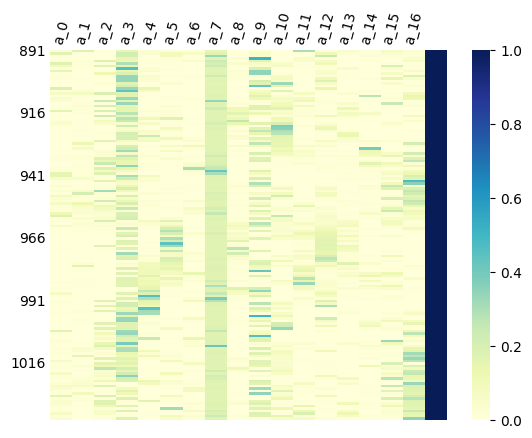

In [150]:
plot_weight_heatmap(weight_table_final,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)

## Portfolio_2 

In [153]:
idx = pd.IndexSlice 
port2_close = raw_df.loc[idx[:], idx[:,'close']]

In [154]:
idx = pd.IndexSlice 
port2_rsi = raw_df.loc[idx[:], idx[:,'rsi']]

In [155]:
idx = pd.IndexSlice 
port2_high = raw_df.loc[idx[:], idx[:,'high']]

In [156]:
idx = pd.IndexSlice 
port2_sma25 = raw_df.loc[idx[:], idx[:,'sma25']]

In [157]:
idx = pd.IndexSlice 
port2_sma200 = raw_df.loc[idx[:], idx[:,'sma200']]

In [158]:
idx = pd.IndexSlice 
port2_volume = raw_df.loc[idx[:], idx[:,'volume']]

## close

In [206]:
close2 = port2_close[['AAPL', 'ADBE','ABT', 'BMY', 'COF', 'GS', 'SPG', 'AMT', 'PM', 'KHC', 'DUK', 'NEE', 'NFLX', 'T', 'XOM', 'COP', 'EMR','LOW', 'MCD']]

In [207]:
df_returns7 = close2.pct_change()
df_returns7 = df_returns7.dropna()
df_returns7.columns = pd.MultiIndex.from_product([['returns'], df_returns7.columns.get_level_values(1)])

In [208]:
torch.manual_seed(4)
np.random.seed(5)
n_timesteps, n_assets = 1100, 19
lookback, gap, horizon = 40, 2, 20
n_samples = n_timesteps - lookback - horizon - gap + 1
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

In [209]:
X_list, y_list = [], []

for i in range(lookback, n_timesteps - horizon - gap + 1):
    X_list.append(df_returns7.iloc[i - lookback:i, :])
    y_list.append(df_returns7.iloc[i + gap:i + gap + horizon, :])

In [210]:
X = np.stack(X_list, axis=0)[:, None, ...]
y = np.stack(y_list, axis=0)[:, None, ...]
means, stds = prepare_standard_scaler(X, indices=indices_train)
dataset = InRAMDataset(X, y, transform=Scale(means, stds))
dataloader_train = RigidDataLoader(dataset, indices=indices_train, batch_size=16)
dataloader_test = RigidDataLoader(dataset, indices=indices_test, batch_size=16)

In [211]:
class GreatNet(torch.nn.Module, Benchmark):
    def __init__(self, n_assets, lookback, p=0.5):
        super().__init__()

        n_features = n_assets * lookback

        self.dropout_layer = torch.nn.Dropout(p=p)
        self.dense_layer = torch.nn.Linear(n_features, n_assets, bias=True)
        self.allocate_layer = SoftmaxAllocator(temperature=None)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        n_samples, _, _, _ = x.shape
        x = x.view(n_samples, -1)  # flatten features
        x = self.dropout_layer(x)
        x = self.dense_layer(x)

        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

In [212]:
network = GreatNet(n_assets, lookback)
network = network.train()
loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio()
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.2),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=20)])

In [213]:
history = run.launch(100)



































































Epoch 0: 100%|██████████| 52/52 [00:01<00:00, 32.52it/s, loss=-0.09061, test_loss=-0.00263]
































































Epoch 1: 100%|██████████| 52/52 [00:01<00:00, 38.43it/s, loss=-0.09271, test_loss=-0.00243]


































































Epoch 2: 100%|██████████| 52/52 [00:01<00:00, 34.10it/s, loss=-0.09507, test_loss=-0.00217]

































































Epoch 3: 100%|██████████| 52/52 [00:01<00:00, 35.94it/s, loss=-0.09805, test_loss=-0.00205]


































































Epoch 4: 100%|██████████| 52/52 [00:01<00:00, 33.12it/s, loss=-0.09999, test_loss=-0.00215]
































































Epoch 5: 100%|██████████| 52/52 [00:01<00:00, 30.90it/s, loss=-0.10495, test_loss=-0.00222]



























































Training interrupted
Training stopped early because there was no improvement in test_loss for 20 epochs


In [214]:
weight_table7 = generate_weights_table(network, dataloader_test)
weight_table7

,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,a_12,a_13,a_14,a_15,a_16,a_17,a_18
891,0.042769,0.107421,0.063497,0.017183,0.045906,0.012255,0.076614,0.036854,0.048275,0.060624,0.062059,0.039367,0.158702,0.043714,0.069851,0.022599,0.030889,0.041344,0.020077
892,0.018428,0.050141,0.032489,0.073196,0.023291,0.024873,0.018121,0.009767,0.009103,0.504450,0.055220,0.003502,0.002601,0.025951,0.019267,0.083578,0.003323,0.022329,0.020370
893,0.022771,0.055703,0.001489,0.060618,0.011920,0.019653,0.011518,0.039315,0.013817,0.072506,0.073214,0.006718,0.108930,0.119594,0.024669,0.176922,0.148854,0.011886,0.019904
894,0.006036,0.045972,0.024409,0.099014,0.018972,0.049076,0.031102,0.009131,0.082013,0.385568,0.034138,0.003804,0.007317,0.026663,0.020214,0.029678,0.041647,0.020636,0.064612
895,0.038531,0.012159,0.017782,0.051432,0.050674,0.042902,0.061602,0.044628,0.002529,0.153773,0.006027,0.006555,0.191977,0.029644,0.020397,0.208888,0.016112,0.035544,0.008845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,0.030517,0.014105,0.077243,0.060308,0.041924,0.033645,0.054981,0.132886,0.005731,0.045519,0.041994,0.008796,0.238255,0.040075,0.019928,0.012436,0.030980,0.012218,0.098457
1035,0.045163,0.014012,0.116269,0.033518,0.051014,0.023350,0.041822,0.027402,0.029376,0.019014,0.023082,0.144907,0.082536,0.078141,0.030667,0.024794,0.185479,0.008076,0.021379
1036,0.022520,0.023194,0.043330,0.032195,0.024076,0.099606,0.034225,0.080483,0.011403,0.125562,0.019786,0.022577,0.037776,0.024700,0.020137,0.033589,0.042197,0.250856,0.051789
1037,0.070870,0.082409,0.078377,0.009128,0.018616,0.010416,0.022088,0.130792,0.005605,0.063466,0.111016,0.068077,0.015962,0.084926,0.019064,0.060591,0.036311,0.006332,0.105954


## rsi

In [226]:
rsi2 = port2_rsi[['AAPL', 'ADBE','ABT', 'BMY', 'COF', 'GS', 'SPG', 'AMT', 'PM', 'KHC', 'DUK', 'NEE', 'NFLX', 'T', 'XOM', 'COP', 'EMR','LOW', 'MCD']]

In [227]:
df_returns8 = rsi2.pct_change()

# Remove the first row since it will have NaN values after computing returns
df_returns8 = df_returns8.dropna()

# Optional: If you want to rename the top-level column index from 'close' to 'returns':
df_returns8.columns = pd.MultiIndex.from_product([['returns'], df_returns8.columns.get_level_values(1)])

In [228]:
torch.manual_seed(4)
np.random.seed(5)
n_timesteps, n_assets = 1100, 19
lookback, gap, horizon = 40, 2, 20
n_samples = n_timesteps - lookback - horizon - gap + 1
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

In [229]:
X_list, y_list = [], []

for i in range(lookback, n_timesteps - horizon - gap + 1):
    X_list.append(df_returns8.iloc[i - lookback:i, :])
    y_list.append(df_returns8.iloc[i + gap:i + gap + horizon, :])

In [230]:
X = np.stack(X_list, axis=0)[:, None, ...]
y = np.stack(y_list, axis=0)[:, None, ...]
means, stds = prepare_standard_scaler(X, indices=indices_train)
dataset = InRAMDataset(X, y, transform=Scale(means, stds))
dataloader_train = RigidDataLoader(dataset, indices=indices_train, batch_size=16)
dataloader_test = RigidDataLoader(dataset, indices=indices_test, batch_size=16)

In [231]:
class GreatNet(torch.nn.Module, Benchmark):
    def __init__(self, n_assets, lookback, p=0.5):
        super().__init__()

        n_features = n_assets * lookback

        self.dropout_layer = torch.nn.Dropout(p=p)
        self.dense_layer = torch.nn.Linear(n_features, n_assets, bias=True)
        self.allocate_layer = SoftmaxAllocator(temperature=None)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        n_samples, _, _, _ = x.shape
        x = x.view(n_samples, -1)  # flatten features
        x = self.dropout_layer(x)
        x = self.dense_layer(x)

        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

In [232]:
network = GreatNet(n_assets, lookback)
network = network.train()
loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio()
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.2),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=20)])

In [233]:
history = run.launch(100)

Epoch 48: 100%|██████████| 52/52 [00:00<00:00, 52.23it/s, loss=-0.13963, test_loss=0.05799]


Training interrupted
Training stopped early because there was no improvement in test_loss for 20 epochs


In [234]:
weight_table8 = generate_weights_table(network, dataloader_test)
weight_table8

,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,a_12,a_13,a_14,a_15,a_16,a_17,a_18
891,0.046381,0.050193,0.020019,0.021466,0.013691,0.016275,0.041933,0.010480,0.014445,0.024388,0.063184,0.115013,0.315630,0.066536,0.034276,0.020886,0.019112,0.085283,0.020808
892,0.023252,0.116885,0.041217,0.160309,0.014018,0.009079,0.027312,0.004618,0.001820,0.277781,0.049035,0.003439,0.002298,0.087158,0.037272,0.016556,0.002873,0.087120,0.037958
893,0.021127,0.022123,0.016775,0.020732,0.007480,0.008820,0.012823,0.057105,0.009174,0.086498,0.029673,0.020625,0.151777,0.236645,0.020346,0.105914,0.076388,0.074602,0.021374
894,0.017504,0.097629,0.058560,0.131672,0.027893,0.035321,0.011018,0.004414,0.044896,0.291512,0.018487,0.004405,0.006824,0.013202,0.010757,0.011375,0.026623,0.150773,0.037135
895,0.043640,0.010460,0.076976,0.050249,0.033604,0.020519,0.063159,0.003908,0.004226,0.081047,0.035758,0.036951,0.042641,0.022840,0.134585,0.115133,0.017664,0.174764,0.031877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,0.009045,0.022686,0.027786,0.016384,0.024847,0.020445,0.079906,0.055312,0.002163,0.270249,0.035483,0.007139,0.210627,0.071793,0.048196,0.015335,0.049889,0.005180,0.027537
1035,0.009878,0.008795,0.035112,0.025297,0.032234,0.018022,0.066405,0.042995,0.003745,0.153159,0.042913,0.068309,0.154288,0.038251,0.030964,0.094123,0.127344,0.041507,0.006661
1036,0.004253,0.018294,0.011741,0.012146,0.007902,0.116402,0.029036,0.088978,0.003305,0.508253,0.016039,0.001458,0.026884,0.007530,0.007099,0.083800,0.027093,0.011244,0.018542
1037,0.022966,0.038947,0.033438,0.003626,0.009116,0.016792,0.045087,0.166124,0.001764,0.274656,0.016622,0.009999,0.018234,0.077273,0.101368,0.021692,0.036944,0.073879,0.031473


## high

In [254]:
high2 = port2_high[['AAPL', 'ADBE','ABT', 'BMY', 'COF', 'GS', 'SPG', 'AMT', 'PM', 'KHC', 'DUK', 'NEE', 'NFLX', 'T', 'XOM', 'COP', 'EMR','LOW', 'MCD']]

In [255]:
df_returns9 = high2.pct_change()

# Remove the first row since it will have NaN values after computing returns
df_returns9 = df_returns9.dropna()

# Optional: If you want to rename the top-level column index from 'close' to 'returns':
df_returns9.columns = pd.MultiIndex.from_product([['returns'], df_returns9.columns.get_level_values(1)])

In [256]:
torch.manual_seed(4)
np.random.seed(5)
n_timesteps, n_assets = 1100, 19
lookback, gap, horizon = 40, 2, 20
n_samples = n_timesteps - lookback - horizon - gap + 1
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

In [257]:
X_list, y_list = [], []

for i in range(lookback, n_timesteps - horizon - gap + 1):
    X_list.append(df_returns9.iloc[i - lookback:i, :])
    y_list.append(df_returns9.iloc[i + gap:i + gap + horizon, :])

In [258]:
X = np.stack(X_list, axis=0)[:, None, ...]
y = np.stack(y_list, axis=0)[:, None, ...]
means, stds = prepare_standard_scaler(X, indices=indices_train)
dataset = InRAMDataset(X, y, transform=Scale(means, stds))
dataloader_train = RigidDataLoader(dataset, indices=indices_train, batch_size=16)
dataloader_test = RigidDataLoader(dataset, indices=indices_test, batch_size=16)

In [259]:
class GreatNet(torch.nn.Module, Benchmark):
    def __init__(self, n_assets, lookback, p=0.5):
        super().__init__()

        n_features = n_assets * lookback

        self.dropout_layer = torch.nn.Dropout(p=p)
        self.dense_layer = torch.nn.Linear(n_features, n_assets, bias=True)
        self.allocate_layer = SoftmaxAllocator(temperature=None)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        n_samples, _, _, _ = x.shape
        x = x.view(n_samples, -1)  # flatten features
        x = self.dropout_layer(x)
        x = self.dense_layer(x)

        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

In [260]:
network = GreatNet(n_assets, lookback)
network = network.train()
loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio()
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.2),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=20)])

In [261]:
history = run.launch(100)

Epoch 32: 100%|██████████| 52/52 [00:01<00:00, 51.68it/s, loss=-0.30538, test_loss=0.00160]


Training interrupted
Training stopped early because there was no improvement in test_loss for 20 epochs


In [262]:
weight_table9 = generate_weights_table(network, dataloader_test)
weight_table9

,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,a_12,a_13,a_14,a_15,a_16,a_17,a_18
891,0.000279,0.029403,0.016444,0.045819,0.002798,0.000730,0.056909,0.454109,0.003882,0.135419,0.015096,0.001001,0.153761,0.006438,0.029402,0.005298,0.001872,0.037673,0.003666
892,0.001455,0.258653,0.021511,0.012264,0.002355,0.000112,0.005580,0.000546,0.001247,0.426654,0.074551,0.000167,0.000467,0.044659,0.017163,0.110573,0.000579,0.016658,0.004807
893,0.000062,0.000740,0.000007,0.033752,0.000556,0.000474,0.001099,0.000694,0.000068,0.902133,0.036645,0.000001,0.001937,0.006290,0.000825,0.007252,0.003551,0.001112,0.002798
894,0.029686,0.002118,0.000150,0.016906,0.000280,0.002020,0.000661,0.002152,0.000326,0.890152,0.024541,0.000001,0.001330,0.014287,0.003389,0.006635,0.003222,0.000976,0.001166
895,0.001166,0.000289,0.001212,0.023316,0.002060,0.004957,0.003615,0.000215,0.000034,0.910197,0.000065,0.000011,0.017963,0.001860,0.004698,0.019149,0.000546,0.008472,0.000175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,0.000985,0.001384,0.027200,0.000211,0.026116,0.001135,0.000359,0.915223,0.000002,0.003766,0.000146,0.000035,0.007754,0.001590,0.000520,0.000081,0.002668,0.000135,0.010690
1035,0.000510,0.000444,0.011758,0.006298,0.047249,0.002373,0.004020,0.565304,0.000219,0.004464,0.006464,0.062861,0.075599,0.033955,0.017362,0.003716,0.030674,0.002764,0.123964
1036,0.004826,0.000602,0.053613,0.002861,0.009267,0.122598,0.010346,0.586191,0.000271,0.026635,0.000723,0.003729,0.079902,0.020300,0.006726,0.007441,0.014973,0.001253,0.047742
1037,0.000286,0.001069,0.053581,0.000145,0.001714,0.001753,0.001459,0.789989,0.000040,0.059655,0.021402,0.001847,0.000918,0.007680,0.000914,0.004124,0.001927,0.000368,0.051127


## sma25

In [263]:
sma25_2 = port2_sma25[['AAPL', 'ADBE','ABT', 'BMY', 'COF', 'GS', 'SPG', 'AMT', 'PM', 'KHC', 'DUK', 'NEE', 'NFLX', 'T', 'XOM', 'COP', 'EMR','LOW', 'MCD']]

In [264]:
df_returns10 = sma25_2.pct_change()

# Remove the first row since it will have NaN values after computing returns
df_returns10 = df_returns10.dropna()

# Optional: If you want to rename the top-level column index from 'close' to 'returns':
df_returns10.columns = pd.MultiIndex.from_product([['returns'], df_returns10.columns.get_level_values(1)])

In [265]:
torch.manual_seed(4)
np.random.seed(5)
n_timesteps, n_assets = 1100, 19
lookback, gap, horizon = 40, 2, 20
n_samples = n_timesteps - lookback - horizon - gap + 1
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

In [266]:
X_list, y_list = [], []

for i in range(lookback, n_timesteps - horizon - gap + 1):
    X_list.append(df_returns10.iloc[i - lookback:i, :])
    y_list.append(df_returns10.iloc[i + gap:i + gap + horizon, :])

In [267]:
X = np.stack(X_list, axis=0)[:, None, ...]
y = np.stack(y_list, axis=0)[:, None, ...]
means, stds = prepare_standard_scaler(X, indices=indices_train)
dataset = InRAMDataset(X, y, transform=Scale(means, stds))
dataloader_train = RigidDataLoader(dataset, indices=indices_train, batch_size=16)
dataloader_test = RigidDataLoader(dataset, indices=indices_test, batch_size=16)

In [268]:
class GreatNet(torch.nn.Module, Benchmark):
    def __init__(self, n_assets, lookback, p=0.5):
        super().__init__()

        n_features = n_assets * lookback

        self.dropout_layer = torch.nn.Dropout(p=p)
        self.dense_layer = torch.nn.Linear(n_features, n_assets, bias=True)
        self.allocate_layer = SoftmaxAllocator(temperature=None)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        n_samples, _, _, _ = x.shape
        x = x.view(n_samples, -1)  # flatten features
        x = self.dropout_layer(x)
        x = self.dense_layer(x)

        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

In [269]:
network = GreatNet(n_assets, lookback)
network = network.train()
loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio()
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.2),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=20)])

In [270]:
history = run.launch(100)

Epoch 21: 100%|██████████| 52/52 [00:00<00:00, 101.38it/s, loss=-4.31016, test_loss=-0.18052]


Training interrupted
Training stopped early because there was no improvement in test_loss for 20 epochs


In [271]:
weight_table10 = generate_weights_table(network, dataloader_test)
weight_table10

,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,a_12,a_13,a_14,a_15,a_16,a_17,a_18
891,0.001536,0.002378,0.002336,0.221993,0.002206,0.001245,0.007784,0.013624,0.112653,0.042687,0.057062,0.000075,0.052977,0.423984,0.022376,0.018628,0.000424,0.016017,0.000015
892,0.000993,0.002292,0.001752,0.253063,0.001513,0.001875,0.004354,0.009056,0.089723,0.037151,0.078728,0.000036,0.040298,0.420633,0.023609,0.020140,0.000368,0.014407,0.000010
893,0.000770,0.002087,0.000993,0.290219,0.001191,0.001103,0.003096,0.006357,0.049125,0.034472,0.100710,0.000020,0.031724,0.427863,0.017450,0.020815,0.000423,0.011578,0.000006
894,0.000430,0.002016,0.001088,0.303911,0.001162,0.001215,0.003198,0.005308,0.041276,0.034569,0.102765,0.000013,0.025391,0.440417,0.012999,0.013840,0.000516,0.009882,0.000004
895,0.000445,0.001778,0.000783,0.321320,0.001414,0.001590,0.002114,0.003995,0.027324,0.037124,0.115035,0.000011,0.032047,0.413182,0.012423,0.017945,0.000585,0.010880,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,0.018114,0.000901,0.137408,0.004300,0.038602,0.051157,0.068775,0.282390,0.043007,0.044307,0.019591,0.150850,0.000055,0.131818,0.001241,0.000197,0.000535,0.000672,0.006080
1035,0.011630,0.001321,0.139712,0.003797,0.058507,0.052025,0.085528,0.267785,0.031022,0.037912,0.025139,0.137170,0.000132,0.139360,0.001365,0.000330,0.000821,0.000511,0.005932
1036,0.010278,0.001334,0.132909,0.003021,0.062519,0.055370,0.088738,0.331495,0.022747,0.030709,0.030830,0.112791,0.000250,0.106639,0.000933,0.000368,0.000854,0.000562,0.007653
1037,0.005537,0.001566,0.175125,0.001876,0.070284,0.043561,0.090912,0.317205,0.014828,0.023663,0.050127,0.080636,0.000505,0.103941,0.001169,0.000550,0.001096,0.000550,0.016870


## sma200

In [272]:
sma200_2 = port2_sma200[['AAPL', 'ADBE','ABT', 'BMY', 'COF', 'GS', 'SPG', 'AMT', 'PM', 'KHC', 'DUK', 'NEE', 'NFLX', 'T', 'XOM', 'COP', 'EMR','LOW', 'MCD']]

In [273]:
df_returns11 = sma200_2.pct_change()

# Remove the first row since it will have NaN values after computing returns
df_returns11 = df_returns11.dropna()

# Optional: If you want to rename the top-level column index from 'close' to 'returns':
df_returns11.columns = pd.MultiIndex.from_product([['returns'], df_returns11.columns.get_level_values(1)])

In [274]:
torch.manual_seed(4)
np.random.seed(5)
n_timesteps, n_assets = 1100, 19
lookback, gap, horizon = 40, 2, 20
n_samples = n_timesteps - lookback - horizon - gap + 1
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

In [275]:
X_list, y_list = [], []

for i in range(lookback, n_timesteps - horizon - gap + 1):
    X_list.append(df_returns11.iloc[i - lookback:i, :])
    y_list.append(df_returns11.iloc[i + gap:i + gap + horizon, :])

In [276]:
X = np.stack(X_list, axis=0)[:, None, ...]
y = np.stack(y_list, axis=0)[:, None, ...]
means, stds = prepare_standard_scaler(X, indices=indices_train)
dataset = InRAMDataset(X, y, transform=Scale(means, stds))
dataloader_train = RigidDataLoader(dataset, indices=indices_train, batch_size=16)
dataloader_test = RigidDataLoader(dataset, indices=indices_test, batch_size=16)

In [277]:
class GreatNet(torch.nn.Module, Benchmark):
    def __init__(self, n_assets, lookback, p=0.5):
        super().__init__()

        n_features = n_assets * lookback

        self.dropout_layer = torch.nn.Dropout(p=p)
        self.dense_layer = torch.nn.Linear(n_features, n_assets, bias=True)
        self.allocate_layer = SoftmaxAllocator(temperature=None)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        n_samples, _, _, _ = x.shape
        x = x.view(n_samples, -1)  # flatten features
        x = self.dropout_layer(x)
        x = self.dense_layer(x)

        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

In [278]:
network = GreatNet(n_assets, lookback)
network = network.train()
loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio()
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.2),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=20)])

In [279]:
history = run.launch(100)

Epoch 48: 100%|██████████| 52/52 [00:00<00:00, 54.70it/s, loss=-6.93399, test_loss=-1.74982]


Training interrupted
Training stopped early because there was no improvement in test_loss for 20 epochs


In [280]:
weight_table11 = generate_weights_table(network, dataloader_test)
weight_table11

,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,a_12,a_13,a_14,a_15,a_16,a_17,a_18
891,0.001440,0.004276,0.001909,0.004462,0.000700,0.001172,0.007699,0.008021,0.008036,0.001136,0.005061,0.014214,0.004115,0.004211,0.005035,0.919256,0.003267,0.000728,0.005263
892,0.001108,0.004096,0.002038,0.003883,0.000675,0.001068,0.007756,0.006508,0.007807,0.001199,0.004673,0.013019,0.003709,0.004088,0.004984,0.924274,0.002995,0.000636,0.005484
893,0.000919,0.003886,0.001773,0.003971,0.000667,0.000974,0.007068,0.005259,0.007393,0.001249,0.004784,0.010600,0.003643,0.004055,0.004875,0.930328,0.002868,0.000587,0.005102
894,0.000876,0.003812,0.001789,0.004415,0.000641,0.000960,0.007386,0.005768,0.007588,0.001158,0.004908,0.011235,0.003722,0.004231,0.005021,0.927431,0.002985,0.000548,0.005526
895,0.000787,0.003819,0.001607,0.004534,0.000651,0.000932,0.007304,0.007142,0.007520,0.001315,0.005054,0.010869,0.003865,0.004282,0.005133,0.926207,0.002956,0.000544,0.005478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,0.000631,0.026357,0.006258,0.021362,0.012184,0.000343,0.006477,0.612112,0.034286,0.003120,0.021770,0.086355,0.022818,0.036651,0.029147,0.023663,0.023520,0.000032,0.032915
1035,0.000759,0.027171,0.006502,0.023116,0.011543,0.000365,0.007267,0.616538,0.035972,0.003486,0.023248,0.076308,0.022368,0.036994,0.029407,0.026301,0.024330,0.000041,0.028283
1036,0.000918,0.033449,0.007263,0.025121,0.011689,0.000432,0.008928,0.587302,0.039298,0.004387,0.024180,0.071854,0.025584,0.037516,0.032242,0.029307,0.027256,0.000055,0.033218
1037,0.000979,0.029786,0.007554,0.024791,0.009416,0.000402,0.008389,0.622735,0.037006,0.004629,0.023926,0.058963,0.024364,0.034892,0.029798,0.030143,0.025688,0.000062,0.026475


## volume

In [298]:
volume_2 = port2_volume[['AAPL', 'ADBE','ABT', 'BMY', 'COF', 'GS', 'SPG', 'AMT', 'PM', 'KHC', 'DUK', 'NEE', 'NFLX', 'T', 'XOM', 'COP', 'EMR','LOW', 'MCD']]

In [299]:
df_returns12 = volume_2.pct_change()

# Remove the first row since it will have NaN values after computing returns
df_returns12 = df_returns12.dropna()

# Optional: If you want to rename the top-level column index from 'close' to 'returns':
df_returns12.columns = pd.MultiIndex.from_product([['returns'], df_returns12.columns.get_level_values(1)])

In [300]:
torch.manual_seed(4)
np.random.seed(5)
n_timesteps, n_assets = 1100, 19
lookback, gap, horizon = 40, 2, 20
n_samples = n_timesteps - lookback - horizon - gap + 1
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

In [301]:
X_list, y_list = [], []

for i in range(lookback, n_timesteps - horizon - gap + 1):
    X_list.append(df_returns12.iloc[i - lookback:i, :])
    y_list.append(df_returns12.iloc[i + gap:i + gap + horizon, :])

In [302]:
X = np.stack(X_list, axis=0)[:, None, ...]
y = np.stack(y_list, axis=0)[:, None, ...]
means, stds = prepare_standard_scaler(X, indices=indices_train)
dataset = InRAMDataset(X, y, transform=Scale(means, stds))
dataloader_train = RigidDataLoader(dataset, indices=indices_train, batch_size=16)
dataloader_test = RigidDataLoader(dataset, indices=indices_test, batch_size=16)

In [303]:
class GreatNet(torch.nn.Module, Benchmark):
    def __init__(self, n_assets, lookback, p=0.5):
        super().__init__()

        n_features = n_assets * lookback

        self.dropout_layer = torch.nn.Dropout(p=p)
        self.dense_layer = torch.nn.Linear(n_features, n_assets, bias=True)
        self.allocate_layer = SoftmaxAllocator(temperature=None)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        n_samples, _, _, _ = x.shape
        x = x.view(n_samples, -1)  # flatten features
        x = self.dropout_layer(x)
        x = self.dense_layer(x)

        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

In [304]:
network = GreatNet(n_assets, lookback)
network = network.train()
loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio()
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.2),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=20)])

In [305]:
history = run.launch(100)

Epoch 20: 100%|██████████| 52/52 [00:00<00:00, 56.99it/s, loss=-335.99677, test_loss=-0.19807]


Training interrupted
Training stopped early because there was no improvement in test_loss for 20 epochs


In [306]:
weight_table12 = generate_weights_table(network, dataloader_test)
weight_table12

,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,a_12,a_13,a_14,a_15,a_16,a_17,a_18
891,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
892,1.062672e-07,2.875555e-07,9.999950e-01,1.202991e-06,1.310201e-07,3.412498e-07,6.023303e-08,1.165991e-07,9.987253e-07,8.489095e-13,6.974504e-08,1.500814e-07,4.109103e-19,2.490977e-07,1.114142e-07,1.085000e-07,3.775832e-07,4.174689e-07,2.196387e-07
893,4.977926e-08,5.067796e-08,5.215174e-14,3.261785e-07,6.747116e-08,7.019625e-08,5.106979e-08,1.103374e-07,1.070228e-07,9.999987e-01,7.329795e-08,5.546450e-08,7.754871e-19,1.010304e-07,3.713121e-08,4.771645e-08,7.071686e-08,3.092238e-08,1.090045e-07
894,9.264280e-06,1.144944e-05,9.666944e-01,1.373556e-06,4.965840e-06,5.044204e-06,7.314224e-06,9.227468e-06,6.667515e-07,4.669744e-09,1.206370e-05,1.668522e-05,3.318997e-02,6.745798e-06,1.092398e-05,8.849207e-06,1.919094e-06,4.195577e-06,4.989452e-06
895,4.212226e-03,1.083649e-02,1.145245e-01,7.427170e-01,6.371081e-03,8.660192e-03,1.280413e-02,6.506474e-03,3.906424e-02,5.753010e-03,8.669802e-04,2.959718e-03,7.096588e-13,5.460855e-03,2.823383e-03,5.891433e-03,1.222586e-02,1.279102e-02,5.531310e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,2.786577e-10,2.952799e-10,9.998597e-01,1.180626e-11,3.120051e-10,4.776713e-10,1.402455e-10,3.059920e-10,6.668912e-10,1.402448e-04,1.638972e-11,2.754996e-10,1.063629e-25,4.034128e-10,2.320010e-10,3.703866e-10,4.464376e-10,2.821448e-10,4.822605e-10
1035,1.571368e-29,2.017761e-30,2.951227e-39,6.108422e-32,8.834708e-30,4.859894e-30,1.657671e-29,1.104003e-29,6.222942e-31,1.000000e+00,3.569424e-29,6.679277e-30,2.906315e-32,4.944681e-30,1.436500e-29,1.216002e-29,1.778020e-30,3.287967e-30,6.916266e-30
1036,7.265045e-04,1.274882e-03,2.573856e-03,1.354825e-02,1.031143e-03,9.561711e-04,6.534274e-04,4.014914e-04,6.047637e-04,8.990229e-03,4.461382e-04,1.033452e-03,9.624664e-01,7.779687e-04,7.651995e-04,8.111781e-04,1.019530e-03,1.255087e-03,6.643491e-04
1037,1.135217e-22,9.294500e-24,4.110025e-23,3.780790e-23,1.913404e-22,7.528814e-23,3.307490e-23,1.410850e-23,3.502226e-23,1.000000e+00,3.093711e-23,1.825204e-23,3.208587e-19,1.998700e-23,1.075766e-22,7.734805e-23,1.334223e-22,9.082384e-23,2.517598e-23


In [308]:
weight_table_final2 = (weight_table7 + weight_table8 + weight_table9 + weight_table10 + weight_table11 + weight_table12)/6

<Axes: >

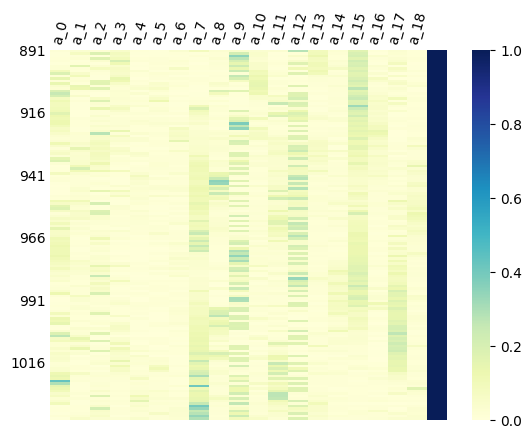

In [309]:
plot_weight_heatmap(weight_table_final2,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)

In [310]:
weight_table_final2

,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,a_12,a_13,a_14,a_15,a_16,a_17,a_18
891,0.015401,0.032278,0.017368,0.051820,0.010884,0.005279,0.031823,0.087181,0.031215,0.044042,0.033744,0.028278,0.280864,0.090814,0.026823,0.164444,0.009261,0.030174,0.008305
892,0.007539,0.072011,0.183167,0.083786,0.006975,0.006168,0.010520,0.005082,0.018283,0.207873,0.043701,0.003360,0.008229,0.097082,0.017049,0.192520,0.001690,0.023525,0.011438
893,0.007608,0.014090,0.003506,0.068215,0.003636,0.005171,0.005934,0.018122,0.013263,0.349476,0.040838,0.006327,0.049669,0.132408,0.011361,0.206872,0.038680,0.016628,0.008197
894,0.009090,0.025260,0.175448,0.092653,0.008159,0.014766,0.008895,0.004464,0.029350,0.267160,0.030809,0.003246,0.012962,0.083134,0.008732,0.164828,0.012499,0.030470,0.018075
895,0.014797,0.006557,0.035481,0.198928,0.015796,0.013260,0.025100,0.011066,0.013449,0.198202,0.027134,0.009559,0.048082,0.079545,0.030010,0.215535,0.008348,0.040499,0.008652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,0.009882,0.010905,0.212626,0.017094,0.023946,0.017788,0.035083,0.332987,0.014198,0.061183,0.019831,0.042196,0.079918,0.046988,0.016505,0.008619,0.017932,0.003040,0.029280
1035,0.011323,0.008624,0.051559,0.015338,0.033424,0.016022,0.034174,0.253337,0.016723,0.203006,0.020141,0.081593,0.055820,0.054450,0.018294,0.024877,0.061441,0.008816,0.031036
1036,0.007254,0.013025,0.041905,0.014816,0.019414,0.065894,0.028654,0.279142,0.012938,0.117423,0.015334,0.035574,0.188810,0.032911,0.011317,0.025886,0.018899,0.044204,0.026601
1037,0.016773,0.025630,0.058013,0.006594,0.018191,0.012154,0.027989,0.337807,0.009874,0.237678,0.037182,0.036587,0.009997,0.051452,0.025386,0.019517,0.016994,0.013532,0.038650
